In [1]:
import pandas as pd
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import collections
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

### HUMAN RESOURCES ANALYTICS

In [2]:
data_dir = '../data/HR_comma_sep.csv'
data = pd.read_csv(data_dir)
data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales   
3                   5              0     1                      0  sales   
4                   3              0     1                      0  sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

### Exploratory analysis

Looks like the salary has something to do with people leaving their jobs!

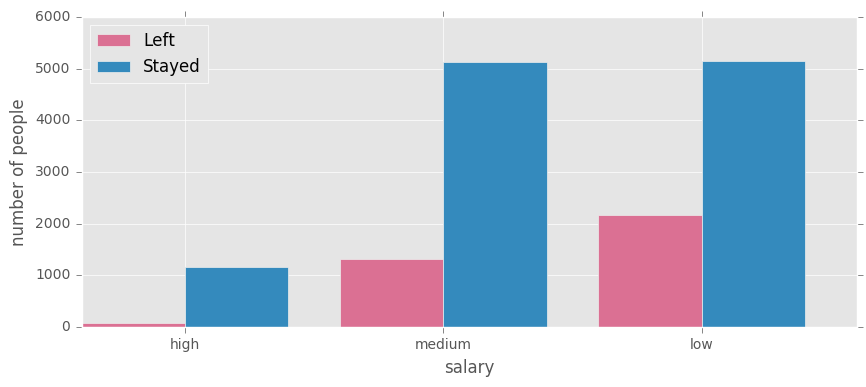

In [3]:
labels, ratios_left = zip(*Counter(data[data.left==1].salary.values).items())
labels, ratios_stayed = zip(*Counter(data[data.left==0].salary.values).items())

indexes = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(10,4))

left = ax.bar(indexes, ratios_left, width, color='#DB7093')
stayed = ax.bar(indexes+width, ratios_stayed, width)

ax.legend((left[0], stayed[0]), ('Left', 'Stayed'), loc=2)

ax.set_ylabel('number of people')
ax.set_xlabel('salary')
ax.set_xticks(indexes + width)
ax.set_xticklabels(('high', 'medium', 'low'))

plt.show()

Whats the mean level of satisfaction for the ones that left and stayed? Avg monthy hours? Avg time spent in the company? Avg number of projects?

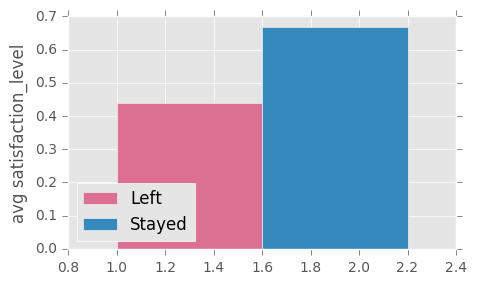

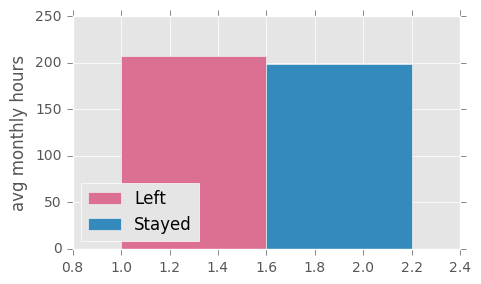

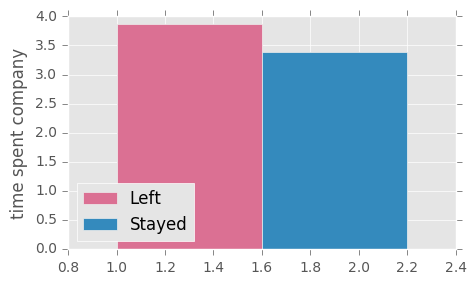

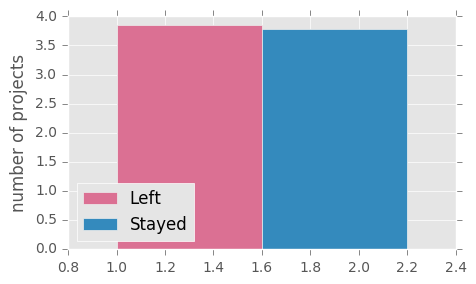

In [4]:
df_left = data[data.left==1]
df_stayed = data[data.left==0]

def avg(df_left, df_stayed, col):
    
    return (df_left[col].mean(), df_stayed[col].mean())

def plotbars(var, ylabel):
    
    width = 0.6
    
    fig,ax = plt.subplots(figsize=(5,3))
    left = ax.bar(1, var[0], width, color='#DB7093')
    stayed = ax.bar(1+width, var[1], width)
    ax.legend((left[0], stayed[0]), ('Left', 'Stayed'), loc=3)
    ax.set_ylabel(ylabel) 

satisfaction_level = avg(df_left, df_stayed, 'satisfaction_level')
avg_montly_h= avg(df_left, df_stayed, 'average_montly_hours')
time_spent = avg(df_left, df_stayed, 'time_spend_company')
num_projects = avg(df_left, df_stayed, 'number_project')

plotbars(satisfaction_level, 'avg satisfaction_level')
plotbars(avg_montly_h, 'avg monthly hours')
plotbars(time_spent, 'time spent company')
plotbars(num_projects, 'number of projects')
    

### ML

In [5]:
#Encoding "salary" and "sales" features to binary vectors for machine learning
data = pd.get_dummies(data)
data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales_IT  \
0                   3              0     1                      0       0.0   
1                   6              0     1                      0       0.0   
2                   4              0     1                      0       0.0   
3                   5              0     1                      0       0.0   
4                   3              0     1                      0       0.0   

   sales_RandD      ...        sales_hr  sales_management  sales_marketing  \
0          0.0      ...             0.0               0.0              0.0   
1          0.0      ...             0.0               0.0              0.0   
2          0.0      ...             0.0               0.0              0.0   
3          0.0      ...             0.0               0.0              0.0   
4          0.0      ...             0.0               0.0              0.0   

   sales_product_mng  sales_sales  sales_support  sales_technical  \
0                0.0          1.0            0.0              0.0   
1                0.0          1.0            0.0              0.0   
2                0.0          1.0            0.0              0.0   
3                0.0          1.0            0.0              0.0   
4                0.0          1.0            0.0              0.0   

   salary_high  salary_low  salary_medium  
0          0.0         1.0            0.0  
1          0.0         0.0            1.0  
2          0.0         0.0            1.0  
3          0.0         1.0            0.0  
4          0.0         1.0            0.0  

[5 rows x 21 columns]

Optimal number of features : 9


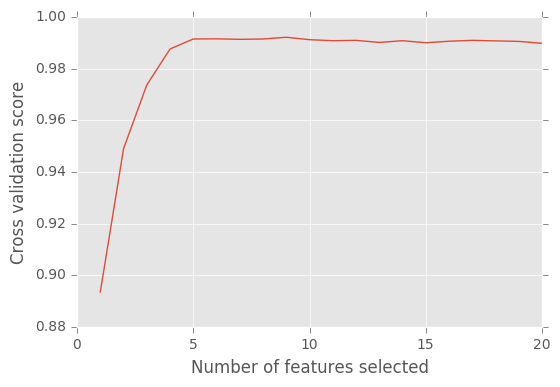

('satisfaction_level', 1)
('last_evaluation', 1)
('number_project', 1)
('average_montly_hours', 1)
('time_spend_company', 1)
('Work_accident', 1)
('promotion_last_5years', 10)
('sales_IT', 6)
('sales_RandD', 9)
('sales_accounting', 7)
('sales_hr', 11)
('sales_management', 5)
('sales_marketing', 8)
('sales_product_mng', 12)
('sales_sales', 1)
('sales_support', 4)
('sales_technical', 2)
('salary_high', 1)
('salary_low', 1)
('salary_medium', 3)


In [6]:
#target
y = data.left.values
#feature matrix
data = data.drop('left', 1)
X = data.as_matrix()

radm_classifier = RandomForestClassifier()
rfecv = RFECV(estimator=radm_classifier, step=1, cv=10,
              scoring='accuracy')
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#show ranking of features
feature_names = data.columns
feature_ranking = rfecv.ranking_
for i in range(len(feature_names)):
    print (feature_names[i], feature_ranking[i])


Taking into account the importance of the features we can just drop the ones that are not relevant for the classification problem.

f1-measure: 0.979919
precision: 0.992288
recall: 0.967881
## Confusion matrix ##
[[ 11401.     27.]
 [   115.   3456.]]


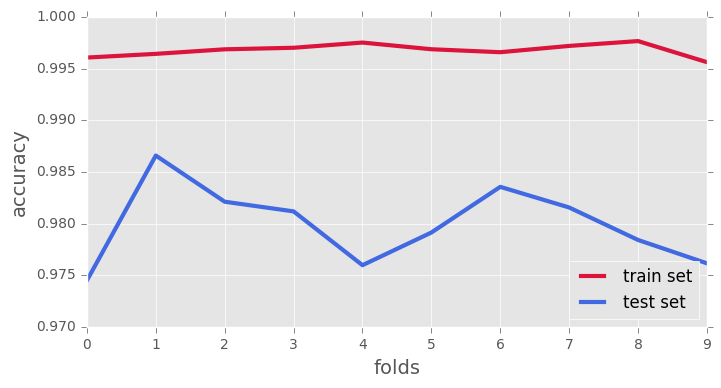

In [7]:
#drop features that are not among the ones ranked as "1"
col_inds = [ind for ind, ele in enumerate(feature_ranking) if ele!=1]
cols_to_drop = [feature_names[i] for ind in col_inds]

data = data.drop(cols_to_drop, 1)
X = data.as_matrix()

N = data.shape[0]
K=10
CV = cross_validation.KFold(N, K, shuffle=True)

f1_vec_train, f1_vec_test, precision_vec_test, recall_vec_test = np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K)
confmat = np.zeros((2,2))
k=0

for train_index, test_index in CV:
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    
    radm_classifier = RandomForestClassifier()
    
    radm_classifier = radm_classifier.fit(X_train, y_train)
    
    y_est_train = radm_classifier.predict(X_train) 
    y_est_test = radm_classifier.predict(X_test)

    f1_train = f1_score(y_train, y_est_train) 
    f1_test = f1_score(y_test, y_est_test) 

    precision_train = precision_score(y_train, y_est_train)
    precision_test = precision_score(y_test, y_est_test)

    recall_train = recall_score(y_train, y_est_train)
    recall_test = recall_score(y_test, y_est_test)
    
    confmat += confusion_matrix(y_test, y_est_test)
    
    f1_vec_train[k], f1_vec_test[k], precision_vec_test[k], recall_vec_test[k] = f1_train, f1_test, precision_test, recall_test

    k+=1
    
print "f1-measure: %f" %np.mean(f1_vec_test)
print "precision: %f" %np.mean(precision_vec_test)
print "recall: %f" % np.mean(recall_vec_test)
print "## Confusion matrix ##"
print confmat

fig = plt.figure(figsize=(8, 4))

train_acc, = plt.plot(f1_vec_train, color = '#DC143C', linewidth = 3 ,label = 'train set')
test_acc, = plt.plot(f1_vec_test, color = '#4169E1', linewidth = 3, label = 'test set')
plt.xlabel('folds', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend(handles=[train_acc, test_acc])
plt.legend(loc=4)